# 多样本数据模型

## Kruskal-Wallis秩和检验

如果我们知道单样本方差分析中那个总体方差是多少，其实我们就可以回避F检验里通过比消掉那个方差的麻烦，
更不用去证明那个麻烦的两个平方和独立的结论。

$$
\frac{1}{\sigma^2} \sum_{i=1}^k n_i(\bar{x}_i - \bar{x})^2 \sim \chi^2(k-1)
$$

在Cochran 的notebook里的讨论我们还发现了$n_i$的决定性用处，虽然没加也是$k-1$秩。但只有加权之后，
我们惊讶的发现$\frac{\sqrt{n_i}}{\sigma}(\bar{x}_i - \bar{x})$协方差矩阵直接变成了对称幂等矩阵，这就直接得到了卡方分布。

在秩的方法里，我们完全照搬上述思路。构造统计量

$$
H = \frac{1}{\sigma^2}\sum_{i=1}^k n_i (\bar{R}_i - \bar{R})^2 = 
\frac{12}{N(N+1)}\sum_{i=1}^k n_i (\bar{R}_i - \bar{R})^2
$$

但是各个秩$R_j$显然不是独立正态分布的，虽然各个分组秩均值$\bar{R}_i$单独看应该是渐进正态分布的，但它们应该是不独立的。
这就使得讨论变得非常麻烦。我们来试验一下是否秩的取值方式可以让它们渐进独立。

remark:注意单独看那个$\sigma^2$应该等于$\frac{(N-1)(N+1)}{12}$而不是$\frac{N(N+1)}{12}$，
这个偏差已经反映了为了让其服从卡方分布所做修正的某些复杂性。

In [40]:
mean.rank <- function(cuts = c(10,20,30,40),size = 1000){ 
    #cuts <- c(10,20,30,40)
    n <- sum(cuts)
    #size <- 1000
    obsl <- c()
    for(i in 1:size){
        permu <- sample(1:n)
        head <- 1
        obs <- c()
        for(len in cuts){
            obs <- c(obs, mean(permu[head:(head+len-1)]))
            head <- head + len 
        }
        obsl <- rbind(obsl, obs)
    }
    return(obsl)
}

In [41]:
cor(mean.rank(c(10,20,30,40)))

1.0000000,-0.1600879,-0.1837223,-0.2964687
-0.1600879,1.0000000,-0.2953396,-0.4272494
-0.1837223,-0.2953396,1.0000000,-0.5516162
-0.2964687,-0.4272494,-0.5516162,1.0000000


In [44]:
cor(mean.rank(c(10,20,30,40)*10))

1.0000000,-0.1991246,-0.2240489,-0.2247874
-0.1991246,1.0000000,-0.2946999,-0.3938685
-0.2240489,-0.2946999,1.0000000,-0.5831481
-0.2247874,-0.3938685,-0.5831481,1.0000000


In [45]:
cor(mean.rank(c(10,20,30,40)*100))

1.0000000,-0.1523421,-0.1896773,-0.3576632
-0.1523421,1.0000000,-0.3496109,-0.4133972
-0.1896773,-0.3496109,1.0000000,-0.4785979
-0.3576632,-0.4133972,-0.4785979,1.0000000


可以看出，各分组平均秩和随规模增长并没有渐进独立的趋势，这就导致在这个步骤归约到常规的方差分析那种形式的尝试失败了。
为了证明上述统计量的确渐进服从$\chi^2(k-1)$分布，得借助其他方法。

事实上我又没想出来，参照陈希儒的《非参数统计教程》P115和P155的内容，可以作出如下说明。

设$n$为总样本规模，$m$为分组数。则对分组$k \in 1,...,m$而言的线性秩和统计量定义为：

$$
L_{nk} = \sum_{i=1}^n c_{ni}^{(k)} a_n(R_i), \quad k = 1,...,m
$$

其中$R_i$是第$i$个观测的秩，$a_n$是记分函数。$c_{ni}^{(k)}$是第$k$组给记分$a_n(R_i)$的加权，经常会给本组以外的数赋0，本组赋1，
这种情况中使用加权记法是为了简化符号。不然要写成那种恶心的分割$n_k$的记法。

符合某些正则条件情况下（大致就是加权和记分不“发散”之类的）。若以下极限都存在

$$
\lim_{n \to \infty} 
\frac{
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )(c_{ni}^{(l)} - \bar{c}_n^{(l)} )
}
{
\sqrt{
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )^2  \sum_{i=1}^n (c_{ni}^{(l)} - \bar{c}_n^{(l)} )^2 
}
}
= \lambda_{kl}
$$

将这些极限做成矩阵$\Lambda = (\lambda_{kl})$

则有，

$$
\begin{bmatrix}
\frac{L_{n1} - E(L_{n1})}{\sigma_{n1}} \\
... \\
\frac{L_{nm} - E(L_{nm})}{\sigma_{nm}}  
\end{bmatrix}
\to
N(0,\Lambda)
$$

注意$\Lambda$并不是对角矩阵，这里做的是保相关的标准化。

极限中$c_{mi}^{(k)}$相当于一个三元函数，每个$n$对应一个不同的三元函数。这个极限反映了这个三元函数的某些性质，
也就是具体对每个整体样本规模$n$，$m$个分组是怎么划分的（加权的）。

如果我们设极限

$$
\frac{n_i}{n} \to p_i  > 0 \quad i = 1,2,...,m
$$

则极限分式上半部分可得到

$$
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )(c_{ni}^{(l)} - \bar{c}_n^{(l)} ) = 
(n-n_l-n_k) p_k p_l + n_k (1 - p_k)(-p_l) + n_l(-p_k)(1 - p_l) = n p_k p_l - n_k p_l - n_l p_k = 
\frac{n_k n_l}{n} - \frac{n_k n_l}{n} - \frac{n_k n_l}{n} = -\frac{n_k n_l}{n}
$$

下半部分可依次得到

$$
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )^2 =
n_k (1 - p_k)^2 + (n - n_k)p_k^2
$$

$$
n_k - 2 p_k n_k + n p_k^2 = n_k - 2\frac{n_k^2}{n} + \frac{n_k^2}{n} = n_k - \frac{n_k^2}{n} = n_k(1 - p_k)
$$


$$
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )^2  \sum_{i=1}^n (c_{ni}^{(l)} - \bar{c}_n^{(l)} )^2  =
n_k(1 - p_k) n_l (1 - p_l)
$$

于是

$$
\lambda_{kl} = 
\frac{
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )(c_{ni}^{(l)} - \bar{c}_n^{(l)} )
}
{
\sqrt{
\sum_{i=1}^n (c_{ni}^{(k)} - \bar{c}_n^{(k)} )^2  \sum_{i=1}^n (c_{ni}^{(l)} - \bar{c}_n^{(l)} )^2 
}
}
=
\frac{
-\frac{n_k n_l}{n}
}
{
\sqrt{n_k(1 - p_k) n_l (1 - p_l)}
}
=
-\sqrt{ \frac{p_k p_l}{(1 - p_k)(1 - p_l)} }
\quad
k \neq l \\
\lambda_{kk} = 1
$$

这样可以定义出$m \times m$的矩阵$\Lambda$，然而它不可逆，我们转而只选取它的左上角的$m-1 \times m-1$子矩阵作为矩阵$\Lambda$。
当然只这么做并不能证明它可逆，我们发现可以通过直接凭空构造一个逆矩阵使其乘积为$m-1$级单位阵来证明这一点。

构造
$$
\Lambda^{-1} 
=
\begin{bmatrix}
1 - p_1 & 0     & \cdots & 0 \\
0     & 1 - p_2 & \cdots & 0 \\
\vdots  & \vdots  & \ddots & \vdots \\
0     & 0     & \cdots & 1 - p_{m-1}
\end{bmatrix}
+
dd^T / p_m
$$

其中
$$
d=(\sqrt{p_1(1-p_1)},...,\sqrt{p_{m-1}(1-p_{m-1}}))^T
$$

可以计算证明其的确为$\Lambda$的逆矩阵。

看上去是完全机械的运算，就是不验证了（好吧我开个头后去吃了个饭，再回来就不想算了）。这里有趣的是线性约束是如何起作用的，
我们那是协方差矩阵秩与去相关标准化。它这是。。。利用约束中导出的$x_m = a_1 x_1 + ...$式关系直接消掉了$x_m$，
然后只用$x_1,...,x_{m-1}$折腾。由于那个关系的存在，想要它出现时候就构造出表达式把它代回来就是。只有$m-1$的表达式去证明
它服从$m-1$自由度的卡方分布显然更自然。

既然$\Lambda^{-1}$的确是$\Lambda$的逆矩阵。我们就可以直接做$(x_1,...,x_{m-1})\Lambda^{-1}(x_1,...,x_{m-1})^T \sim \chi^2(m-1)$。
这是具有满秩的协方差矩阵的随机向量的特权。展开二次型$(x_1,...,x_{m-1})\Lambda^{-1}(x_1,...,x_{m-1})^T $的表达式，我们可以从中
代回$x_m$，然后凑成某个看的上眼的统计量形式，然后我们就自然得到该统计量服从$\chi^2(m-1)$。比如抽象的$T_n$统计量。

$$
T_n = \frac{n-1}{D_n} \sum_{i=1}^m n_i (L_{n_i}/n_i - \bar{a}_n)^2 \sim \chi^2(m-1)
$$

在取记分函数取恒等映射$a_n(r) = r$，即直接的秩和时，我们得到Kruskal-Wallis统计量与卡方分布的关系。

$$
H = T_n = \frac{12}{n(n+1)} \sum_{i=1}^m n_i (R_i - \frac{n+1}{2})^2 \sim \chi^2(m-1)
$$

从这个证明中我们得到了一个套路，因为满秩协方差矩阵的随机向量可以自然地服从卡方分布。
对于有不满秩（自由度小于变量数）的协方差矩阵的随机向量。我们可以先取其极大线性无关组，自然地论证其与卡方分布后再经过线性组合关系
把之前失踪的变量代回来，凑成所有变量都出现的形式。如果所证命题真的正确，就一定凑的出来。

虽然没有必要，但也可以得到对称于方差分析的F检验的$F^*$统计量。

$$
F^* = \frac{ \sum_{i=1}^m n_i(\bar{x}_i - \bar{x})^2 / (k-1) }
{ \sum_{i=1}^m \sum_{j=\sum_{k=1}^{m-1} n_k + 1}^{\sum_{k=1}^{m} n_k} (x_j - \bar{x}_i)^2  / (n-k)}
\sim F(n-1,n-k)
$$

KW统计量的精确分布可以采用置换检验的思想，可以定义为遍历每个排列，每个排列对应一个统计量值与一个相同的概率。再合并起来就得到了精确分布。
虽然这么定义比较直观，但复杂度感人。我们也可以在第一组中构成所有可能组合，再在第二组中构成残余元素所有组合。。这样。

In [1]:
3**14

[1] 4782969

In [4]:
prod(1:14)

[1] 87178291200

In [5]:
prod(10:14)/prod(1:5) * prod(5:9) / prod(1:5) * prod(1:4) /prod(1:4)

[1] 252252

In [209]:
pierce <- function(x, n){
    
    if(length(x)==n){
        return(matrix(x,1,length(x)))
    }
    if(n == 1){
        return(matrix(x,length(x),1))
    }
        
    rm <- NULL
    for(i in 1:(length(x)-n+1)){
        cbinded <- cbind(x[i],pierce(x[(i+1):length(x)],n-1))
        rm <- rbind(rm, cbinded)
    }
    return(rm)
}

In [216]:
pierce(c(1,2,3,4),3)

1,2,3
1,2,4
1,3,4
2,3,4


In [220]:
pierce(c(1,2,3,4,5,6),1)

1
2
3
4
5
6


In [197]:
group <- function(x, nk){
    if(length(nk)==1){
        return(matrix(x,1,length(x)))
    }
    self.res <- NULL
    perm.mat <- pierce(1:length(x),nk[1])
    #print(perm.mat)
    for(i in 1:nrow(perm.mat)){
        #cat('x',x,'nk',nk,'i',i,'select',x[perm.mat[i,]],'res.select',x[-perm.mat[i,]],'\n')
        group.res <- group(x[-perm.mat[i,]],nk[2:length(nk)])
        left.matrix <- matrix(rep(x[perm.mat[i,]],nrow(group.res)),nrow(group.res),nk[1],byrow=TRUE)
        self.res <- rbind(self.res, cbind(left.matrix,group.res))
    }
    return(self.res)
}

In [210]:
group(c(1,2,3,4),c(2,2))

1,2,3,4
1,3,2,4
1,4,2,3
2,3,1,4
2,4,1,3
3,4,1,2


In [211]:
mat <- group(1:6,c(2,2,2))

head(mat)

1,2,3,4,5,6
1,2,3,5,4,6
1,2,3,6,4,5
1,2,4,5,3,6
1,2,4,6,3,5
1,2,5,6,3,4


In [201]:
6*5/2 * 4*3/2

[1] 90

In [214]:
nrow(mat)

[1] 90

In [221]:
seq(10,60,10)

[1] 10 20 30 40 50 60

In [223]:
head(group(seq(10,60,10),c(2,2,2)))

10,20,30,40,50,60
10,20,30,50,40,60
10,20,30,60,40,50
10,20,40,50,30,60
10,20,40,60,30,50
10,20,50,60,30,40


In [224]:
mat2 <- group(1:14,c(5,5,4)) # It cost 10+ second to run. Terriable efficiency ,shamed.

In [225]:
nrow(mat2)

[1] 252252

In [309]:
S.H.1 <- function(data,nk){
    #n <- sum(nk)
    #mean.R <- (n+1)/2
    head <- 1
    res <- NULL
    for(k in nk){
        res <- cbind(res, apply(data[,head:(head+k-1)],1,mean))
        head <- head + k
    }
    return(res)
}

S.H.2 <- function(means,nk){
    n <- sum(nk)
    mean.R <- (n+1)/2
    H <- apply((means - mean.R)**2 %*% diag(nk),1,sum) * (12/(n*(n+1)))
    return(H)
}

S.H <- function(data,nk){
    means <- S.H.1(data,nk)
    return(S.H.2(means,nk))
}

In [230]:
mat3 <- S.H.1(mat2,c(5,5,4))

In [234]:
apply(mat3,2,mean)

[1] 7.5 7.5 7.5

In [235]:
apply(mat3,2,median)

[1] 7.5 7.5 7.5

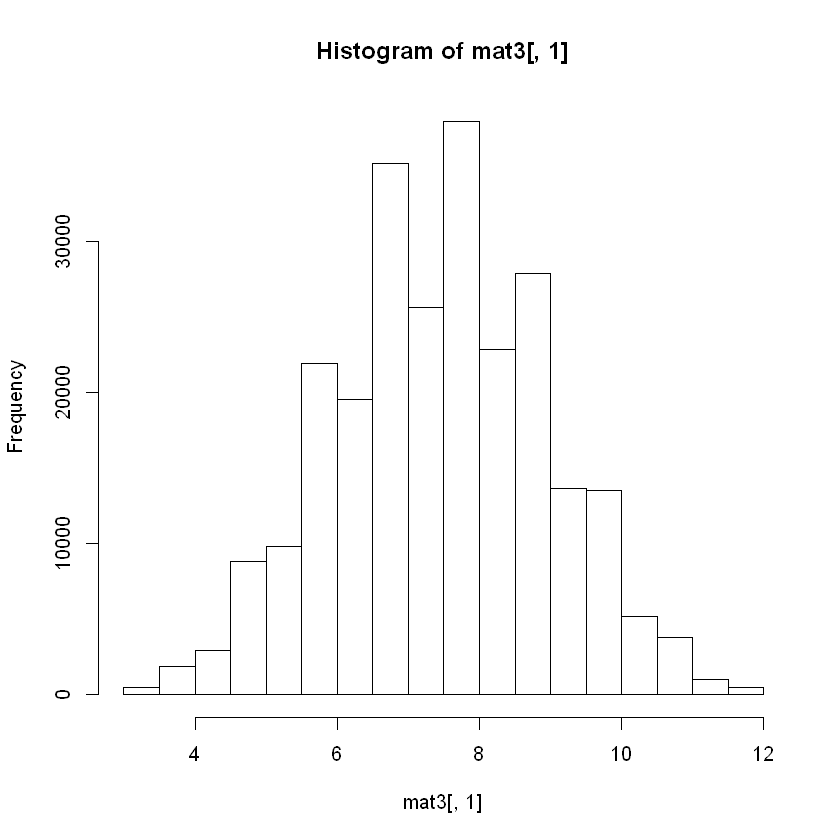

In [236]:
hist(mat3[,1])

In [237]:
cov(mat3)

2.250009,-1.250005,-1.250005
-1.250005,2.250009,-1.250005
-1.250005,-1.250005,3.125012


In [310]:
mat4 <- S.H.2(mat3,c(5,5,4))

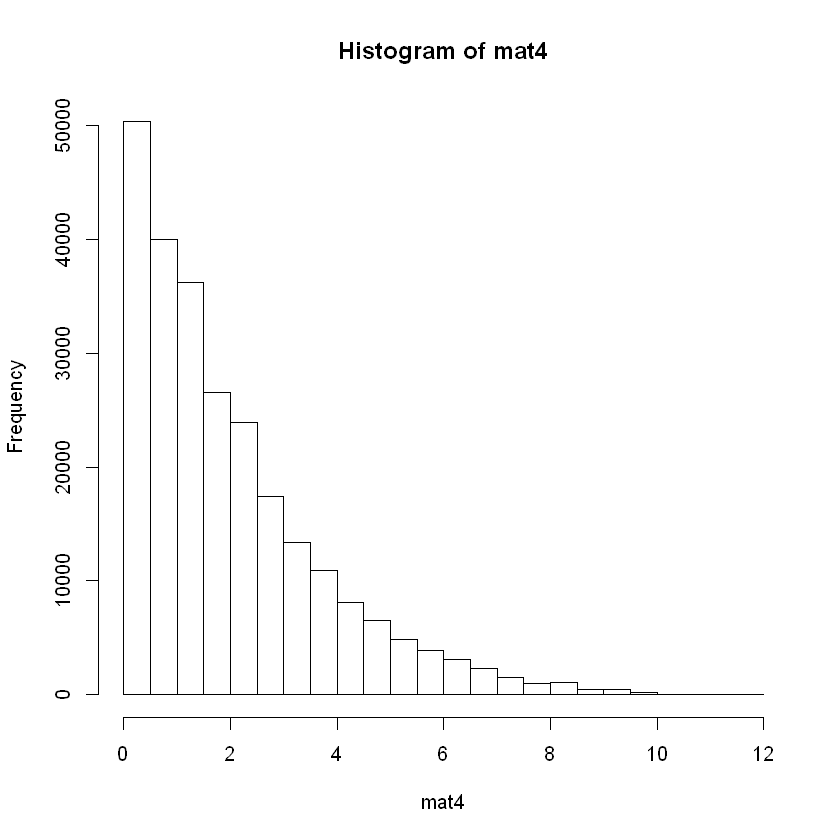

In [311]:
hist(mat4)

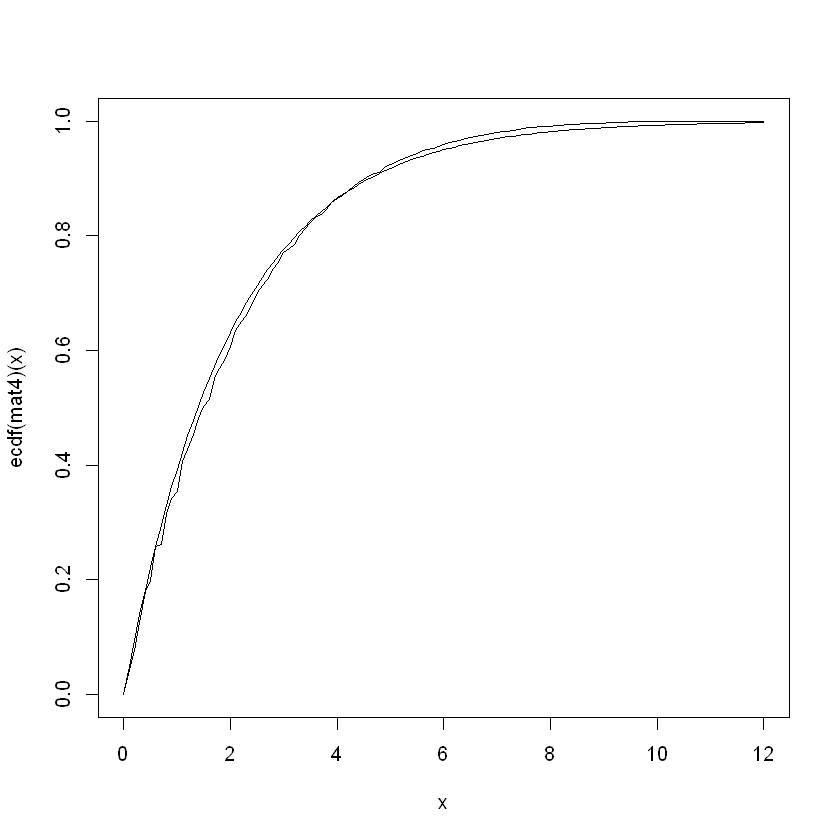

In [318]:
x <- seq(0,12,0.1)

plot(x,ecdf(mat4)(x),'l')


y <- pchisq(x,2)

lines(x,y,type="l")

可以看出精确分布的确与渐进的卡方分布十分接近。

In [3]:
wtloss <- c(3.7, 3.7, 3.0, 3.9, 2.7, 
            7.3, 5.2, 5.3, 5.7, 6.5,
            9.0, 4.9, 7.1, 8.7)
wtloss.nk <- c(5,5,4)

In [322]:
sh <- S.H(rbind(rank(wtloss),rank(wtloss)),wtloss.nk) # fuck the auto simplify
sh

[1] 9.411429 9.411429

In [323]:
H <- sh[1]
H

[1] 9.411429

In [324]:
pchisq(H,2,lower.tail=FALSE)

[1] 0.009043452

In [325]:
1-ecdf(mat4)(H)

[1] 0.001157573

In [331]:
kruskal.test(wtloss,rep(1:length(wtloss.nk),wtloss.nk))


	Kruskal-Wallis rank sum test

data:  wtloss and rep(1:length(wtloss.nk), wtloss.nk)
Kruskal-Wallis chi-squared = 9.4322, df = 2, p-value = 0.00895


In [329]:
rep(1:length(wtloss.nk),wtloss.nk)

[1] 1 1 1 1 1 2 2 2 2 2 3 3 3 3

In [333]:
1-ecdf(mat4)(H-0.01)

[1] 0.001347858

和书上结果正好差在自变量上0.01?也许是ecdf或书上暗中做了某些处理导致不一致。之前可能也是因为这个，总之大体一致。

## 正态记分检验

$$
T = (n-1) \frac{
\sum_{i=1}^k (\frac{1}{n_i}(\sum_{j=1}^{n_i} \omega_{ij}^2)  )
}
{
\sum_{i=1}^k \sum_{j=1}^{n_i} \omega_{ij}^2
}
\to
\chi^2(k-1)
$$

其中

$$
\omega_{ij} = \Phi^{-1} (\frac{r_{ij}}{n+1})
$$

是为正态记分。

In [4]:
normal.score <- function(r){
    n <- length(r)
    return(qnorm(r/(n+1)))
}

omega <- normal.score(rank(wtloss))
omega

[1] -0.72791329 -0.72791329 -1.11077162 -0.43072730 -1.50108595  0.84162123
 [7] -0.08365173  0.08365173  0.25334710  0.43072730  1.50108595 -0.25334710
[13]  0.62292572  1.11077162

In [336]:
rank(wtloss)

[1]  3.5  3.5  2.0  5.0  1.0 12.0  7.0  8.0  9.0 10.0 14.0  6.0 11.0 13.0

此处书上的处理方式是无视结，随便排了个序赋予秩，似乎不好，这将导致不唯一的结果。

In [6]:
wtloss.group <- rep(1:3,wtloss.nk)
wtloss.group

[1] 1 1 1 1 1 2 2 2 2 2 3 3 3 3

In [16]:
tapply(wtloss,wtloss.group,mean)

1     2     3 
3.400 6.000 7.425

In [26]:
n <- sum(wtloss.nk)

In [29]:
T <- (n-1) * sum(tapply(omega,wtloss.group,sum)**2 * (1/wtloss.nk)) / (sum(omega**2))
T

[1] 9.078947

In [30]:
pchisq(T,2,lower.tail=FALSE)

[1] 0.01067903

## Jonckheere-Terpstra检验

比较其Kruskal-Wallis检验，Jonckheere-Terpstra检验把备择假设空间约束到了一个单调递增的方向。

$$
\begin{align}
H_0 &: \theta_1 = \cdots = \theta_k \\
H_1 &: \theta_1 \le \cdots \le \theta_k \quad \text{(There exist a $\lt$ in sequence)}
\end{align}
$$

撤销部分备择假设空间后，可以把那部分参数成立下检验统计量集中而留下那部分不集中的区域划给接受域，把更接近留下部分转给接受区域。
这种变化就带来剩下的备择假设空间上的功效函数值上升，至少不会下降，因为如果所有改变都带来下降，至少可以根本不改变。

当然这是即使检验统计量和以前一样就能得到的结果，事实上，一般来说我们可以选择更优的检验统计量。为此设

$$
U_{ij} = \#(X_{ik} < X_{jl} ,\; k = 1,\ldots,n_i,\, l=1,\ldots ,n_j),
$$

为样本$i$与样本$j$的笛卡尔积中，满足左边小于右边关系的对数。

Jonckheere-Terpstra统计量就是把所有满足$i<j$的样本对对应的$U_{ij}$相加。或者可以看成$U$矩阵所有对角线右上的元素相加。

$$
J = \sum_{i<j} U_{ij}
$$

其原假设成立下的分布显然也可以用类似上面Kruskal-Wallis的方法导出精确分布，也容易看出更加麻烦了。大样本下可以得到正态近似

$$
E(J) = (N^2 - \sum_{i=1}^k n_i^2)/4 \\
Var(J) = N^2(2N+3) - \sum_{i=1}^k n_i^2 (2n_i + 3)/72 \\
Z = \frac{J - E(Z)}{\sqrt{Var(J)}} \to N(0,1)
$$

在原假设成立下也应该有对角线是$n_k(n_k-1)/2$，对角线上两边元素倾向于分布均衡，如果备择假设空间包含小于或大于，
我们要考虑某侧对角线上的元素小或大。要是包含一些其他的非单调情况，则会出现那种情况和原假设的统计量分布无法分辨的情况。
那种情况虽然定性上看与单调情况不应该有什么区别，但在那些参数点却有着很低的功效，而且这种点非常多。
这时我们发现根本不应该用Jonckheere-Terpstra统计量，因为换用其他能分辨出那些参数的统计量可以取得更高的功效。
虽然在单调的参数上可能略降一些，但如果我们真是想设定那种备择假设，
就应该弃用Jonckheere-Terpstra统计量而改用Kruskal-Wallis统计量之类的。正如如果真的把备择假设设为单调的，
就应该舍弃Kruskal-Wallis统计量选用Jonckheere-Terpstra统计量来达到严格更优的功效。

使用JT统计量的一个特点是，因为有很多与原假设几乎完全混淆却又完全不一样的非单调参数赋值，所以从那些（大量）的情况中为真时，
我们都在以比如95%错误率作出决定。比如说，把$U$矩阵分成四份，我们发现右上的右和上部分一个很大，另一个很小，但加和后就貌似符合原假设了。

In [31]:
wtloss

[1] 3.7 3.7 3.0 3.9 2.7 7.3 5.2 5.3 5.7 6.5 9.0 4.9 7.1 8.7

In [32]:
table(wtloss)

wtloss
2.7   3 3.7 3.9 4.9 5.2 5.3 5.7 6.5 7.1 7.3 8.7   9 
  1   1   2   1   1   1   1   1   1   1   1   1   1 

In [5]:
fission <- function(dat, index){
    # c(1,2,3,4,5,6),c(1,1,1,2,2,3) -> list(c(1,2,3), c(4,5), c(6))
    dic <- list()
    for(i in 1:length(dat)){
        if(is.null(dic[index[i]][[1]])){
            dic[[index[i]]] <- dat[i]
        }
        else{
            dic[[index[i]]] <- c(dic[[index[i]]],dat[i])
        }
    }
    return(dic)
}

U.mat <- function(pop.list){
    # list(c(1,2,3), c(4,5), c(6)) -> [3,6,3; 0,1,2; 0,0,0]
    k <- length(pop.list)
    mat <- matrix(nrow = 3, ncol = 3)
    for(i in 1:k){
        for(j in 1:k){
            mat[i,j] <- sum(outer(pop.list[[i]],pop.list[[j]],'-') < 0)
        }
    }
    return(mat)
}

J.stat <- function(H){
    # [3,6,3; 0,1,2; 0,0,0] -> 6+3+2=11
    r <- 0
    k <- ncol(H)
    for(i in 1:(k-1)){
        for(j in (i+1):k){
            r <- r + H[i,j]
        }
    }
    return(r)
}

Z.score <- function(J,nk){
    N <- sum(nk)
    EJ <- (N^2 - sum(nk^2))/4
    VarJ <- (N^2 * (2 * N + 3) - sum(nk^2 * (2 * nk + 3)))/72
    Z <- (J - EJ)/sqrt(VarJ)
    return(Z)
}

In [78]:
dic <- fission(wtloss,rep(c(1,2,3),wtloss.nk))
dic

[[1]]
[1] 3.7 3.7 3.0 3.9 2.7

[[2]]
[1] 7.3 5.2 5.3 5.7 6.5

[[3]]
[1] 9.0 4.9 7.1 8.7

In [80]:
sum(outer(dic[[1]],dic[[2]],'-') < 0)

[1] 25

In [86]:
U.mat(dic)

9,25,20
0,10,14
0,6,6


这里$U_{11}=9$而不是$10$是因为第一个样本存在打结。

In [108]:
J <- J.stat(U.mat(dic))
J

[1] 59

In [113]:
Z <- Z.score(J,wtloss.nk)
Z

[1] 3.103362

In [114]:
pnorm(Z,lower.tail=FALSE)

[1] 0.0009566765

功效比前面的检验不知道高到哪里去了，当然，这是备择假设空间缩减的效果，
试想我们把备择假设空间退缩到到什么$\theta_1 = \ldots = \theta_{k-1} = 0,\theta_{k} = 1000000$这样的单点集上。自然很容易就可以拒绝。
而且我们发现一个问题，此时拒绝了原假设，也并不代表备择假设就多真了，说不定还是原假设更接近真实情况一些
（最大似然的情况现在既不在原假设空间也不在备择假设空间）。当然，原假设和备择假设空间一般是出于外生的目的而决定的，
假设检验干的事就是选择检验统计量和划分检验统计量拒绝域来使得满足给定显著性水平基础上使得势函数在备择假设空间上的值最大化。
不过这里显著性水平一般却是一个灵活的概念，因为假设检验的统计量和划分方法对于各个$\alpha$给出的原则是一致的，增大减小只不过是
拒绝域的一些单调大小变化而已。反倒经常是知道p值（如果p值有恰当定义）后再去选显著性水平。

在$k=3$时，备择假设空间充满了$R^3$除了原假设占据的直线外的所有点。收缩到$\theta_1 < \theta_2 < \theta_3$后，
就成了$R^3$空间3个平面划分8块中的一块。我们可以先考察新的备择假设空间上各个假设成立时对应统计量的分布
(对非参数而言可能要指定背后分布，不过直观上也可以随便举一个，因为一般对所有背后分布我们感兴趣的定性性质都一致)，
这也可以通过数字特征如期望来看，这时和看势函数有类似之处。观察到备择假设空间上相对原假设空间上统计量（主要是集中趋势）的不同之处后，
我们再划分拒绝域，整出势函数。

## 区组设计回顾

将因素分为处理(treatment)和区组(block)是应用的需要。并没有什么理由禁止我们倒换两因素的“处理”和“区组”的地位。
说到底，我们相当于在做一个关于模型中部分参数的假设检验，假设对参数约束的不完全性使得我们失去了以往的全部同分布的便利性。
在无重复因素双因素方差分析中，原假设相当于假设各个“区组”因素对应的总体是不一样的，
区组里本来经过不同处理的观测被看做同分布（每个“区组”一个分布）的。显然，如果区组和处理都有“影响”，
则每个格的分布一般都是不同的。这里的部分假设相当于废掉了部分变异性。

于是在此原假设成立下，对每个处理的在所有区组的观测的平均也是同分布的，这个平均是在几个出自不同的总体的随机变量间平均，
和平时那个的平均不一样。但因为所有处理的这个平均所平均的那几个总体都是对应一样的且数量一致（这种情况都是1个），
所以处理的平均就是同分布的，相应的，区组的对应平均就是普通的平均，且各均值间本来就应该不集中，因为没有假设约束它们位置一致。

当然这是原假设的确成立的情况，假如处理还是有影响，则各从处理计算的均值就会产生明显的偏离，这可以以处理均值与总均值
（原假设成立时总均值可以看成是同分布的处理均值的均值，或对其期望更准确地估计）的差的平方和表示。偏离比较大时，
该平方和的集中位置也会比较大。

在正态假设下，那种单观测双因素表那样的小样本也可以由正态分布的性质得到各个处理均值服从正态分布，
从而可以标准化做成$\chi^2$统计量，如果不知道方差再进一步做成$F$统计量。如果表很大的话，均值会处理会渐进正态分布，
此时各分组什么形状就不重要了，但方差应该一样（因为标准化无论如何都会用到方差或协方差），
如果不一样还要处理就应该事先调整尺度把它们变成一样的。这就是无交互效应的双因素方差分析。

每个格单观测容易推导到多观测情况（但各格观测数还得是相同的），显然处理方式没什么差别。另一个扩展方式是可以缺一些格的方式，
用这个方法好像不好理解，可能看成回归更好。而在多因素下，被我们假设为没有效应的那个因素的“轴”上的元素看成是其他因素笛卡尔积的样本，
样本内看做是同一分布的，样本间看成是一般不同分布的，可照搬前面思路构造统计量。对处理因素的各个多因素区组的各个观测取平均之类的。
而且这么看的话各格的观测数好像也不一定需要是相同的，这样看处理均值到底是什么样子的。
另外其他因素笛卡尔积没有利用方差分析给定的线性假设的简化，这一简化在双因素时没有体现出来。这一简化在允许使用的分布上产生了一些约束，
上面提到的搞法有点非参数的感觉。

不完全区组设计貌似可以试图放处理的平均值，然后规约为之前的问题。

不完全区组设计的BIBD（Balanced Incomplete Block Design）以$BIBD(k,b,r,t,\lambda)$编码一个设计。
其中$k$为试验矩阵的行数,$b$为试验矩阵的列数。$r_i$为$i$行的和，若都相同就记为$r$，$t_j$为$j$列和，若都相同则记为$t$。
$\lambda_{ij}$是第$i,j$行同时为1的次数，或者说两行构成的向量内积的和。

BIBD试验矩阵的一个例子如

$$
\begin{bmatrix}
0 & 1 & 1 & 1 \\
1 & 0 & 1 & 1 \\
1 & 1 & 0 & 1 \\
1 & 1 & 1 & 0
\end{bmatrix}
$$

其中各行看成各个处理，各列看成各个区组。上面是$BIBD(4,4,3,3,2)$的一个实例。令其为$M$，$M_{12}=1$表示第一个处理在第二区组中进行一次试验。
其余类推。

## Friedman 秩和检验

$$
Q = \frac{12}{bk(k+1)}\sum_{i=1}^k \left(R_i - \frac{b(k+1)}{2} \right)^2
$$

其中$R_i=\sum_{j=1}^b R_{ij}$，而$R_{ij}$为格$ij$上的观测在区组$.j$上的秩。也就是分组的不同位置性被内部计算秩给控制成了相对标准化的秩。

其中
$$
E(R_i) = \frac{k(k+1)}{2} b \frac{1}{k} = \frac{b(k+1)}{2}
$$

是先按列计秩和（$\frac{k(k+1)}{2}$），再把所有这样的列秩和加起来$b$，最后除以行数得到每行平均秩和，因为对称性也必然是行总体的期望。另外，

$$
Var(R_i) = \frac{bk(k+1)}{12}
$$

这是因为，考虑一个离散均匀分布随机变量$X$的方差
$$
Var(X) = \frac{(N+1)(N-1)}{12}
$$
单独对于一个处理的求和来说，$b$个格相当于$b$个独立的这样的随机变量。所以方差即所直接和
$$
\frac{(k+1)(k-1)}{12}b
$$

我们发现如果看成独立的在平方和外去除方差进行标准化，结果与上式给出的并不一致，虽然当$\N \to +\infty$时渐进等价。
这是因为在真正处理时还是要进行去相关的标准化


显然，以处理计算的秩和$R_i$结合了本处理在各个分组上对位置影响的信息。如果像原假设假设的那样没有影响的话，则按分组区分总体，
可以看成分组内出自同一个分布，这个时候若按分组求平均，则情况看上去类似Kruskal-Wallis统计量在它的原假设成立下的情况，
然而却并不是，KW统计量的格的秩是把所有样本混合的结果，而Friedman秩和的格的秩是区组内部计算的，显然区组算出的秩的位置要比
KW统计量的小，这一点被$\bar{R}$比$\frac{b(k+1)}{2}$大所调整过来。
然而我们实际是按处理求秩和，为什么不按分组求平均秩呢？

看起来其实秩和才是本体，前面那是因为各个分组的样本数不一样，为了标准化才求的平均，再重加权。
当然这里如果真写成均值再重加权也会得到一样的结果，只不过它的权都是一样的就连平均的那个分母一起提出来放到最外面当系数了，就是那个$b$。

注意各区间独立，组内同分布，导出的组内的格上的秩统计量在组内并不是独立的，（某列第一格取1秩了，该列其他格就不能取1秩）。
各组间的秩统计量依然独立，但是却并不能得到按行看与按列看是同分布的结论，显然一行可以取秩为$1,1,\ldots,1$而按列看却不能。
但是根据对称性，按行看的确是同分布的，但不独立，于是按处理计的秩和或平均秩也是同分布但不独立的。
当然Kruskal-Wallis统计量在各分组的平均秩之间也是这种同分布但不独立的情况，
但我们依然可以通过一些复杂的论证发现这些相关可以在近似正态和卡方分布上可以与独立得到相同的结果，
虽然它们本身并不独立，就像KW统计量上发生的一样，它们只是计算格秩和秩和，平均秩的方式有些区别，带来它们做的标准化略有区别，
但最后结果都是一样的。

$$
Q \to \chi^2_{k-1}
$$

In [428]:
blead <- data.frame(treatment = c('A','A','A','A','B','B','B','B','C','C','C','C'),
                    block = c('I','II','III',"IV",'I','II','III',"IV",'I','II','III',"IV"),
                    value  = c(80, 100, 51, 65, 52, 76, 52, 53, 40, 52, 34, 35))
blead

treatment,block,value
A,I,80
A,II,100
A,III,51
A,IV,65
B,I,52
B,II,76
B,III,52
B,IV,53
C,I,40
C,II,52


In [2]:
for (bk in unique(blead$block)){
    blead[blead$block == bk,'rank'] = rank(blead[blead$block == bk,'value'])
}

In [3]:
blead

treatment,block,value,rank
A,I,80,3
A,II,100,3
A,III,51,2
A,IV,65,3
B,I,52,2
B,II,76,2
B,III,52,3
B,IV,53,2
C,I,40,1
C,II,52,1


In [10]:
Rk <- tapply(blead$rank, blead$treatment,sum)
Rk

A  B  C 
11  9  4

In [5]:
tapply(blead$rank, blead$treatment,mean)

A    B    C 
2.75 2.25 1.00

In [7]:
k <- length(unique(blead$treatment))
k

[1] 3

In [8]:
b <- length(unique(blead$block))
b

[1] 4

In [9]:
R.bar <- (k+1)*b/2
R.bar

[1] 8

In [12]:
Q <- 12/((k+1)*k*b) * sum((Rk - R.bar)^2)
Q

[1] 6.5

In [14]:
pchisq(Q,2,lower.tail=FALSE)

[1] 0.03877421

In [2]:
airp.value <- c(9, 2, 4,10, 7, 6, 8, 5, 3, 1,
                10,1, 3, 8, 7, 5, 9, 6, 4, 2,
                8, 4, 2,10, 9, 7, 5, 6, 3, 1,
                9, 1, 2,10, 6, 7, 4, 8, 5, 3)
airp.value

[1]  9  2  4 10  7  6  8  5  3  1 10  1  3  8  7  5  9  6  4  2  8  4  2 10  9
[26]  7  5  6  3  1  9  1  2 10  6  7  4  8  5  3

In [3]:
airp.est <- rep(c("A","B","C","D"),c(10,10,10,10))
airp.est

[1] "A" "A" "A" "A" "A" "A" "A" "A" "A" "A" "B" "B" "B" "B" "B" "B" "B" "B" "B"
[20] "B" "C" "C" "C" "C" "C" "C" "C" "C" "C" "C" "D" "D" "D" "D" "D" "D" "D" "D"
[39] "D" "D"

In [4]:
airp.city <- rep(c("A","B","C","D","E","F","G","H","I","J"),4)
airp.city

[1] "A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "A" "B" "C" "D" "E" "F" "G" "H" "I"
[20] "J" "A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "A" "B" "C" "D" "E" "F" "G" "H"
[39] "I" "J"

In [5]:
airp <- data.frame(est = airp.est, city = airp.city, value = airp.value)
airp

est,city,value
A,A,9
A,B,2
A,C,4
A,D,10
A,E,7
A,F,6
A,G,8
A,H,5
A,I,3
A,J,1


## Kendall 协同系数检验

Kruskal-wallis和Friedman的统计量都有的格都是独立同分布的，但前者通过把格的值放在一起得到秩，后者在区组内部取得秩。
于是秩随机变量在前者是完全不独立的，在后者则在各区组间独立。两者都某种意义上使用平均秩和与期望的平均秩和的偏离的加总来构成统计量。
由于对称性，这些平均秩和都是同分布的，但因为是秩这种向量内部不独立的分布，所以肯定是不独立的。
因为它们的格的秩的来源不同，所以它们标准化所用的期望和方差是不一样的，虽然都为常数。
这些统计量在假设成立时都渐进服从$\chi^2(k-1)$分布。这个用减了均值估计量减去了相关性解释显然不合适，因为它减的实际上是参数常数，
是难得可以直接不被迫使用估计量的情况。其实际原因显然是秩和之间的线性组合关系，
比如显然我们知道了$k-1$个秩和就可以推出最后一个秩和的值。这就导致其协方差矩阵不可逆，本质上也只能做成服从$\chi^2(k-1)$分布的平方和。

Kendall协同系数检验某种意义上反而比KW,Friedman检验还简单。它在零假设中直接假设了向量秩分布，
而不是像KW,Friedman通过在原假设中将背后分布约束成独立同分布去得到向量秩分布。

Kendall列出与Friedman检验类似的处理-区组矩阵，它们的模型元假设都是区组是有效应的，不然也没必要单独列出来。然而

Friedman 检验的原假设是处理对各格没有效应，或者说造成的效应没有区别。于是可以推出各个区组*列*随机向量秩间是独立同分布的。

Kendall 协同系数检验的原假设是处理会完全扰乱（破坏）区组的效应，同时它们自己的也没有效应，
或者说处理引入了独立同分布的无限大噪声于背后分布上，于是可以推出各个处理*行*随机向量秩间是独立同分布的。
由于这种噪声的说法有些蹩脚，我们也可以直接说Kendall协同系数检验原假设就是直接假设了行随机向量秩间独立同分布。这里处理没有任何作用。

然而Kendall的备择假设可以看成这种无限大噪声开始衰减，区组在元假设中本来就有的效应开始浮现出来。这与Friedman检验中处理的效应开始浮现不同。
显然，像Friedman备择假设中，如果处理效应浮现——或者说以它们的按行区分的值开始不同——来自不同位置的总体，
容易想到，这一点在按行记的秩的模式却无法捕捉，它们的分布并不会产生任何变化。只有按列计的秩，秩和，平均秩的分布才会变化。
如果参数的确落在备择假设上，它的概率就主要集中在以原假设划分的拒绝域中，使得我们容易拒绝他，也就是有较高的功效。
所以我们在Friedman检验中要在列上求秩，不只是为了区组控制，也为了之后的高功效。

Kendall协同系数检验中并不使得处理的效应浮现出来，实际上在模型元假设中处理就已经没有效应了，故原假设和备择假设里都没有这个效应。
备择假设中只恢复区组的效应以示与原假设的区别，这种不一致有时令我们将Kendall协同系数的那个矩阵的原处理叫做评估，区组叫做个体。
当然这里处于区组或个体地位的都被元假设认为是有效应的，而处理或评估则起码被怀疑这一点。

Kendall恢复区组效应时，各区组分布间的差异开始浮现出来，然而这一点在按列计的秩里却无法捕捉这一点，于是我们改为从行计秩，
再在列上取和。与Friedman的正好相反。

这种貌似的对偶性是不是让我们可以认为Kendall是一种Friedman的转置的检验呢？虽然出自不同原因，
在原假设上它们一个可以得到列随机向量秩之间独立同分布，另一个可以得到行上的。备择假设都是另一个上的效应开始浮现从而产生偏差。
故而计算方式也是对偶的，然而它们的结论却不是对偶的。假如我们的确进行了一个转置的Friedman检验并拒绝了原假设，
我们实际上是在已经承认处理有效应的同时证明了区组也有效应。但对于不转置的Kendall协同系数检验来说，
却是已经承认了区组（个体）有效应的同时证明了处理（处理）的干扰效果不完全，其对区组效应的压制低于随机误差容忍的范围内。

某种意义上，这说明在同一个统计量结果上，我们给出不同的模型元假设，就可以得到不同的推断结论。显然同时使用两个结论是没有意义的，
比如若我们元假设假设了处理有效，然后根据拒绝结果得出区组也有效，然后我们干脆利用这个统计结论再元假设区组和统计量落在拒绝域有效去证明...
什么？处理的干扰效果不完全？事实上Kendall元假设就假设了处理没效应，但你在前一个推论中已经设了处理有效应，
显然使用矛盾的前提可以推出任何结论，终结。

### 协同系数W

Kendall协同系数除了与Fridman对偶的计算方式与不同的证明对象外，还导出一个有意义的统计量,协同系数W。其定义为

$$
W = \frac{S}{\frac{m^2(n^3-n)}{12}}
$$

其中$m,n$分别对应之前的$k,b$（比较时不要忘了已经是对偶了，不是简单对应）。而$S$则为各秩和与原假设期望秩和的偏移的平方和

$$
S = \sum_{i=1}^n \left (R_i - \frac{m(n+1)}{2} \right)^2
$$

应该说本体是$S$，$W$那个分母只是$S$可能取到的最大值，用于标准化。于是$W \in [0,1]$

从描述统计上看，$W$值越大说明处理通过很大噪声压制区组效应的效果越不明显，或者说这些处理间越“协同”
（因为越尊重原区组效应意味着，这些“评价”，“处理”越倾向于打出，显示出一致，协同的结果）

最后的对偶统计量也可以用$W$简化表示

$$
m(n-1)W = \frac{12S}{mn(n+1)} = \frac{12}{mn(n+1)}\sum_{i=1}^k \left(R_i - \frac{m(n+1)}{2} \right)^2 \sim \chi^2(n-1)
$$


In [7]:
head(airp)

est,city,value
A,A,9
A,B,2
A,C,4
A,D,10
A,E,7
A,F,6


In [17]:
m <- length(unique(airp$est))
n <- length(unique(airp$city))

R <- tapply(airp$value, airp$city, sum)
S <- sum((R - (1+n)/2*m)^2)
W <- S * (12/(m^2*(n^3-n)))
K <- m*(n-1)*W

In [18]:
W

[1] 0.8530303

In [19]:
K

[1] 30.70909

In [20]:
pchisq(K,n-1,lower.tail=FALSE)

[1] 0.0003320349

这就是说我们可以相信评估不是随机的。或者说处理没有随机到完全压制区组的效应。

我们来试试真随机重排一下会得到什么结果。

In [24]:
for (est in unique(airp$est)){
    airp[airp$est == est,"value"] <- sample(airp[airp$est == est,"value"])
}

In [25]:
airp

est,city,value
A,A,10
A,B,9
A,C,8
A,D,2
A,E,5
A,F,3
A,G,6
A,H,4
A,I,1
A,J,7


In [26]:
R <- tapply(airp$value, airp$city, sum)
S <- sum((R - (1+n)/2*m)^2)
W <- S * (12/(m^2*(n^3-n)))
K <- m*(n-1)*W



In [27]:
W

[1] 0.380303

In [28]:
K

[1] 13.69091

In [29]:
pchisq(K,n-1,lower.tail=FALSE)

[1] 0.1337528

的确就不能拒绝了，不过这个协同系数还是有点高？。。p值也接近拒绝边缘了。也许这是一次看起来“随机性很差”的重排（毕竟什么都不变也是有概率的。）

## 二元响应Cochran检验

### 打结问题

In [2]:
candid <- data.frame(
    A = c(0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1),
    B = c(1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,1,0,0,0,0),
    C = c(0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0),
    D = c(0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0)
)
candid

A,B,C,D
0,1,0,0
1,1,1,0
1,0,1,0
0,0,1,0
0,0,1,1
1,1,0,1
1,1,0,0
1,1,0,0
1,1,0,1
1,1,1,0


In [31]:
Ni <- apply(candid,2,sum)
Lj <- apply(candid,1,sum)

k <- ncol(candid)
b <- nrow(candid)
N <- sum(Ni)

Q <- (k*(k-1)*sum((Ni - mean(Ni))^2))/(k*N - sum(Lj^2))
Q

[1] 9.352941

In [32]:
pchisq(Q,k-1,low=F)

[1] 0.0249484

In [23]:
# 《非参数统计方法》 Cochran检验例子

mat <- matrix(c(c(1,1,1,1,1,1),
                c(1,1,0,1,1,1),
                c(0,0,0,1,0,0),
                c(0,1,0,0,1,1)),
             4,
             byrow=T)
mat

1,1,1,1,1,1
1,1,0,1,1,1
0,0,0,1,0,0
0,1,0,0,1,1


In [39]:
Ni <- apply(mat,1,sum)
Lj <- apply(mat,2,sum)

k <- nrow(mat)
b <- ncol(mat)

N <- sum(Ni)

Q <- (k*(k-1)*sum((Ni - mean(Ni))^2))/(k*N - sum(Lj^2))
Q

[1] 9.315789

In [40]:
pchisq(Q,k-1,low=F)

[1] 0.025374

Cochran检验也是基于卡方渐进性的检验。在原假设下，各行如何出现1,0是同分布不独立的。我们可以以各行和作为卡方的基本统计量。
然后将其标准化再加起来得到一个服从卡方分布的统计量。为此需要分析行和的期望和方差。

Cochran检验基于一种随机模型设定，
认为每个列的给出1的总数确定，但怎么给是随机的（这就是给1,0同分布不独立的一个实现）。偏到某列在某行的格上，其取1的概率是$L_j/k$
其期望是$E(X_{ij}) = L_j/k$，其方差是$Var(X_{ij}) = E(X_{ij}^2) - E(X_{ij})^2 = L_j/k - L_j^2/k^2$。

于是行和$N_i$的偏方差与偏期望为

$$
E(N_i) = \sum_{j=1}^b E(X_{ij}) = \sum_{j=1}^b L_j/k = \frac{N}{k} = \bar{N} \\
Var(N_i) = \sum_{j=1}^b (E(X_{ij}^2) - E(X_{ij})^2) = \bar{N} - \frac{1}{k^2} \sum_{j=1}^b L_j^2 \\
$$

于是我们似乎期待Cochran检验的Q统计量是这样定义的

$$
Q =
\sum_{i=1}^k \left(\frac{N_i - E(N_i)}{\sqrt{Var(N_i)}} \right)^2
=
\frac{1}{Var(N_i)} \sum_{i=1}^k (N_i - E(N_i))^2
= 
\frac{k^2}{kN -  \sum_{j=1}^b L_j^2} \sum_{i=1}^k (N - \bar{N})^2
$$

就像t检验和前面进行的类似分析一样，出现了一些小偏差，实际统计量是这样定义的

$$
Q = \frac{k(k-1)}{kN -  \sum_{j=1}^b L_j^2} \sum_{i=1}^k (N - \bar{N})^2
$$

有一个$k$变成了$k-1$，我们知道这种变化背后往往蕴含着大坑。这里当然是因为各行间并不完全独立的结果，
而如果我们背后随机模型设定是，列无限制的以$\frac{L_j}{k}$概率打出1而不是只能在现有个数上分配，也许就是那个更直接的结果了。

原假设成立下，Q统计量自然渐进服从卡方分布。

$$
Q \sim \chi^2(k-1)
$$

In [42]:
Q2 <- (k*k*sum((Ni - mean(Ni))^2))/(k*N - sum(Lj^2))
Q2

[1] 12.42105

In [43]:
pchisq(Q2,k,low=F)

[1] 0.01448004

我们看到那个假设背后是无限制打出1的模型似乎可以给出更低的p值，那为什么还要做有限制假设呢？也许是为了保护原假设。

可以看出在有限制原假设下，打出特定的$L_j$的概率是$1$。而无限制打出模型中，虽然概率是这类模型中可能的最大值，但综合后一般却很接近$0$
这就把这个不标准化的信息揉进了假设检验中，使得原假设更容易被拒绝，而这在原假设成立下也成立，于是会扩大检验统计量的接受区域。

好吧，感觉这样说还是有点问题。于是我们来试试比较假设不同背后分布下，它们的功效函数是什么情况。

背后模型1

模型被进一步确定为每个行列各对应一个特定概率，各格由行列对应概率乘积打出1,0.原假设下各行概率相同，备择假设上开始背离这个设定。

背后模型2

模型被进一步确定为每个列对应特定整数个1，每个行有一个加权。按列与列的1数与行的加权给各格打出1,0。与按假设上各行加权一样，备择假设上开始背离这个设定。

一个假设检验，本身是个函数，将样本可能取值映射映为接受或拒绝原假设（以0,1编码也行，只不过是一种形式主义。）。
这一过程一般还可以分解为从样本计算一个检验统计量的值，再看该值是否落在拒绝域中作出映射中拒绝与否决策。

那么在指定样本的背后的概率分布后，假设检验就变成一个0,1随机变量。如果这个背后概率分布是原假设下确定的（比如原假设确定或限制了参数的取值）
，此时拒绝或检验统计量落入拒绝域的概率就是第一类错误概率。当是在备择假设下确定的，则落入接受域的概率称为第二类错误概率。无论什么时候，
落入拒绝域的概率称为功效函数的值。功效函数一般表示为足以完全确定分布的参数组对该参数组下检验统计量落入拒绝域的概率。

对于我们非参数检验来说，假设，即使是原假设很少可以完全确定背后分布的。比如位置检验经常出现这样的元假设：几个总体间至多位置不同，
原假设只是说位置相同。元假设加上原假设却未确定分布是什么分布，正态分布还是指数分布什么的。当然有用的就在于无论其实是什么分布，
都可以拒绝位置参数是否相同的假设。然而对功效来说却并非如此。

假设检验抽象的作为一个由样本取值映射到0,1的函数的性质使得我们可以轻易模拟得出功效函数。对于一个特定的参数取值，完全确定分布后
（也就是已经封装成一个不用传参就可以调用的函数的时候），我们可以直接模拟若干次，以0,1出现比例为功效函数在此参数组，以及原假设或
备择假设的这个特例上的取值。当假设空间是一个一维的参数空间时，可视化功效函数特别容易，但正如多维函数一般的可视化困难，
功效函数也不能幸免。更糟的是有的假设空间甚至不是有限个参数可遍历它的每个点的，比如“位置为0的所有分布”。
这时通过模拟我们只能观察它的某些特例上的取值，理论上一般的结果得到前，只通过模拟也许会出现一个奇异的新分布造成一个完全不同的结果的情况。

In [45]:
c(1,1,2) %in% c(0,1)

[1]  TRUE  TRUE FALSE

In [383]:
hypothesis.power <- function(par, rdis, test = NULL, statistic = NULL, in.reject = NULL, size = 1000){
    # par :- vector or matrix. It includes parameter what will sender to `rdir` function to draw many sample
    # rdis :- element of par -> (randomization) sample
    # test :- single sample -> 0,1 0 mean not-rejuect 1 means reject
    # statistic :- single sample -> statistic value
    # in.reject :- statistic value -> 0,1 if test is not given, `statistic` and `in.reject`is needed for build `test`
    # size :- for one power function value, test times
    #
    # return :- (list) par -> power function value
    
    if(is.vector(par)){
        par <- matrix(par,length(par))
    }
    
    if(is.null(test)){
        test <- function(sample){
            return(in.reject(statistic(sample)))
        }
    }
    
    rl <- c()
    for(i in 1:nrow(par)){
        p <- par[i,]
        rl[i] <- mean(replicate(size, test(rdis(p))))
    }
    return(rl)
}

In [239]:
place.weight <- function(n, weight){
    # (2,c(0.45,0.45,0.1)) -> c(1,1,0) or c(1,0,1),... by weight `weight`
    r <- rep(0,length(weight))
    w <- weight
    idx <- 1:length(weight)
    for(i in 1:n){
        tl <- (cumsum(w) - runif(1) * sum(w))
        for(j in 1:length(tl)){
            if(tl[j]>0){
                r[idx[j]] = 1
                w <- w[-j]
                idx <- idx[-j]
                break
            }
        }
    }
    return(r)
}


In [240]:
mat <- replicate(1000,place.weight(2,c(0.45,0.45,0.1)))

apply(mat,1,mean)

[1] 0.859 0.860 0.281

In [331]:

k <- 4
b <- 10

alpha <- 0.05

par <- seq(-1,1,0.1) # par -> 0 mean null hypothesis or near it.
rdis1 <- function(p){
    rp <- rep(0.5,k) + (1:k/k*2 - 1) * p / 2
    cp <- 1:b/b
    pp <- rp %o% cp
    s <- matrix(sapply(pp,function(prob){
        rbinom(1,1,prob)
    }),nrow(pp))
    return(s)
}
rdis2 <- function(p){
    if(p != 0){
        bias <- (1:k) * p / sum(1:k)
        weight <- bias + rep(1/k,k) * (1 - sum(bias))
    }
    else{
        weight <- rep(1/k,k)
    }
    cn <- sapply(trunc(1:b/b*k),function(n)max(1,min(k-1,n)))
    mat <- sapply(cn,function(n){
        place.weight(n,weight)
    })
    return(mat)
}


In [305]:
apply(replicate(100,apply(rdis1(0),1,sum)),1,sum)

[1] 259 266 282 272

In [317]:
apply(replicate(100,apply(rdis1(1),1,sum)),1,sum)

[1] 143 282 421 553

In [320]:
apply(replicate(100,apply(rdis1(-1),1,sum)),1,sum)

[1] 416 268 140   0

In [298]:
apply(replicate(100,apply(rdis2(0),1,sum)),1,sum)

[1] 477 489 468 466

In [299]:
apply(replicate(100,apply(rdis2(1),1,sum)),1,sum)

[1] 273 444 535 648

In [300]:
apply(replicate(100,apply(rdis2(-1),1,sum)),1,sum)

[1] 652 557 441 250

In [394]:
statistic1 <- function(mat){
    Ni <- apply(mat,1,sum)
    Lj <- apply(mat,2,sum)

    k <- nrow(mat)
    b <- ncol(mat)

    N <- sum(Ni)

    Q <- (k*(k-1)*sum((Ni - mean(Ni))^2))/(k*N - sum(Lj^2))
    return(Q)
}

statistic2 <- function(mat){
    Ni <- apply(mat,1,sum)
    Lj <- apply(mat,2,sum)

    k <- nrow(mat)
    b <- ncol(mat)

    N <- sum(Ni)

    Q <- (k*k*sum((Ni - mean(Ni))^2))/(k*N - sum(Lj^2))
    return(Q)
}

In [399]:
hypothesis.power(c(-1,-0.5,0,0.5,1),rdis1,statistic = statistic1, in.reject = in.reject1)

[1] 0.443 0.099 0.036 0.110 0.377

In [406]:
hypothesis.power(c(-1,-0.5,0,0.5,1),rdis1,statistic = statistic2, in.reject = in.reject2)

[1] 0.523 0.141 0.052 0.134 0.464

In [401]:
hypothesis.power(c(-1,-0.5,0,0.5,1),rdis2,statistic = statistic1, in.reject = in.reject1)

[1] 0.272 0.074 0.048 0.075 0.258

In [404]:
hypothesis.power(c(-1,-0.5,0,0.5,1),rdis2,statistic = statistic2, in.reject = in.reject2)

[1] 0.331 0.124 0.055 0.111 0.356

可以看出第二种方法貌似在稳定满足0.05显著性水平上似乎表现不佳。

In [420]:
mean(replicate(100,hypothesis.power(0,rdis1,statistic = statistic2, in.reject = in.reject2,size=100)))

[1] 0.0545

In [423]:
mean(replicate(100,hypothesis.power(0,rdis2,statistic = statistic2, in.reject = in.reject2,size=100)))

[1] 0.0608

给人一种用错了拒绝域的感觉，可能那个还是不是它的精确分布吧。

In [425]:
mean(replicate(100,hypothesis.power(0,rdis1,statistic = statistic1, in.reject = in.reject1,size=100)))

[1] 0.0371

In [426]:
mean(replicate(100,hypothesis.power(0,rdis2,statistic = statistic1, in.reject = in.reject1,size=100)))

[1] 0.0395

总之即使是为了显著性水平约束真起作用了，也得用书上方法。不然要不限制功效函数在原假设成立上的集合的取值，当当然可以要多大有多大。

## Page检验

Page检验进行相同于Jonckheere-Terpstra检验的原假设备择假设设定。那种$\theta_1 \le \cdots \le \theta_k \quad (\text{exist a <})$
备择假设设定使得这些检验可以使用一些可以在对称备择假设下在一个情况下取得大值，在对偶的
（比如$\theta_1 \ge \cdots \ge \theta_k  \quad (\text{exist a >})$）情况下就取得小值的顺序相关的统计量。
对称假设下这种统计量总有一些情况会使得它表现不好，而我们先验认为那些情况与其他情况具有同等地位
（不然就应该撤出备择假设，像JT与Page检验做的那样），所以不会去使用它们。但在对称性破坏的条件下，我们就可以用它们了。

Page检验使用这么个顺序相关的统计量。

$$
L = \sum_{i=1}^k iR_i
$$

在备择假设成立时显然会偏大，但显然在可能的对偶的备择假设上它会偏小，或者在顺序混杂的情况中会与与按假设分布区分不出来。
如果备择假设包含后者将使得拒绝域划分进退两难，所幸既然备择假设只包含这个，我们只需要把偏大的划分为拒绝域即可。
比如得到p值为0.03后，我们就知道左边某个点可以划分出一个满足0.05显著性水平的拒绝域加以拒绝。

$L$在原假设下具有渐进正态性，当$b \to \infty$，这是因为原假设若成立，则各区组的秩列向量都是独立同分布的，
单独看一个行秩和的话，相当于每列提供一个独立离散均匀分布随机变量求和。所以各秩和是同分布渐进正态不独立的，
中心极限定理在加权（这里的加权是$1,2,3,\ldots$）不发散和随机变量列相关程度不大时仍然成立。这就是$L$渐进正态性的来源。

为了推导出$L$的标准化统计量$Z_L$，求其期望与方差

$$
E(R_i) = \frac{k+1}{2}b \\
Var(R_i) =  b Var(R_{ij}) = \frac{1}{12} b (k+1)(k-1) \\
E(L) = \frac{(k+1)k}{2} E(R_i) = \frac{bk(k+1)^2}{4} \\
$$

$Var(L)$稍微有点麻烦，前面已经指出了它不是独立的，所以不能直接算加权和，但我们不妨按错误方法算一下看看得到了什么。

$$
\bar{Var(L)} = \sum_{i=1}^k i^2 Var(R_i) = (\frac{1}{3} k^3 + \frac{1}{2} k^2 + \frac{1}{6} k ) \frac{1}{12} b (k+1)(k-1)
$$

而正确答案是

$$
\sigma_L^2 = \frac{b(k^3-k)^2}{144(k-1)} = \frac{bk^2(k^2-1)^2}{144(k-1)} = \frac{bk^2(k-1)(k+1)^2}{144}
$$

它们的阶姑且还是对的上的,但是细节估计又是大坑。

In [432]:
library(reshape2)

In [471]:
cd <- dcast(blead, treatment ~ block)
cd

treatment,I,II,III,IV
A,80,100,51,65
B,52,76,52,53
C,40,52,34,35


In [472]:
cd[4,] <- cd[1,]
cd[1,] <- cd[3,]
cd[3,] <- cd[4,]
cd <- cd[1:3,]
rownames(cd) <- cd$treatment[3:1]
cd$treatment <- NULL
cd

,I,II,III,IV
A,40,52,34,35
B,52,76,52,53
C,80,100,51,65


In [473]:
apply(cd,2,rank)

,I,II,III,IV
A,1,1,1,1
B,2,2,3,2
C,3,3,2,3


In [474]:
k <- nrow(cd)
b <- ncol(cd)

In [475]:
L <- 1:3 %*% apply(apply(cd,2,rank),1,sum)
L

55


In [476]:
mu <- b*k*(k+1)^2/4
sigma2 <- b*(k^3-k)^2/(144*(k-1))

In [477]:
Z <- (L - mu)/sqrt(sigma2)
Z

2.474874


In [478]:
pnorm(Z,low=F)

0.006664164


比Friedman的0.0x不知道高到哪里去了。理由当然和之前JT检验讨论的类似。
另外也可以注意到这种单向性是就不需要利用平方和消除互相抵消的变异了。可以说平方和，用非参数方法直接定住方差，用估计量抵消方差都是套路，
当假设空间结构不那么混乱时，也就自然不需要它们了。

## Durbin检验

完全区组设计连续情况的全相等，存在不相等假设在正态分布假设下是无重复因素二元素方差分析。在非参数情况下是Friedman检验。
在扩展到$BIBD(k,b,r,t,\lambda)$，即包含不完全区组设计后，就得到了Durbin检验，Friedman检验是Durbin检验的特例。

Friedman检验的检验统计量Q

$$
Q = \frac{12}{bk(k+1)}\sum_{i=1}^k \left(R_i - \frac{b(k+1)}{2} \right)^2
$$

Durbin的检验统计量D

$$
D = \frac{12(k-1)}{rk(t^2-1)}\sum_{i=1}^k \left(R_i - \frac{r(t+1)}{2} \right)^2
$$

显然在$r=kb,t=k$条件下两者等价，而这正好是完全区组设计的定义。

$$
D \to \chi^2(k-1) \quad (r \to \infty)
$$

检验统计量什么的与Friedman完全类似，其秩和相对下降已经由内部期望调整的标准化所控制。它的拒绝域划分推导和前面的也差不多，
什么秩列独立同分布，行秩和同分布不独立之类的。。。正好可以绕过缺失数据的困难，倒是让人好奇参数版本怎么做的，插个均值再调整一番？




In [7]:
mater <- matrix(c(   c(34,28,36,NA),
                     c(36,30,NA,45),
                     c(40,NA,48,60),
                     c(NA,44,54,59)),
                   4,byrow=T)
rownames(mater) <- c('A','B','C',"D")
colnames(mater) <- c('I',"II","III","IV")
mater

,I,II,III,IV
A,34,28,36,NA
B,36,30,NA,45
C,40,NA,48,60
D,NA,44,54,59


In [15]:
rm <- apply(mater,2,function(arr){rank(arr,na.last='keep')})
rm

,I,II,III,IV
A,1,1,1,NA
B,2,2,NA,1
C,3,NA,2,3
D,NA,3,3,2


In [22]:
ri <- apply(rm,1,function(arr){sum(arr,na.rm=TRUE)})
ri

A B C D 
3 5 8 8

In [24]:
k <- 4
t <- 3
r <- 3
l <- 2

D <- 12*(k-1)/(r*k*(t^2-1)) * sum((ri - r*(t+1)/2)^2)
D

[1] 6.75

In [25]:
pchisq(D,k-1,low=FALSE)

[1] 0.08030773